In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

C:\Users\User\AppData\Local\Temp\ipykernel_4588\1358793649.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data observation

In [2]:
df = pd.read_csv('local_global_res_13_12.csv')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,  inplace=True)
df.head(5)

,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,naming_orig,model_name,dataset_name,horizon,split,pred_time
0,3.812914,4.442261,18.260277,619.323792,24.886217,0.896638,0.792087,inf,16.386864,danish_atm_daily_5,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,test,NaN
1,3.485261,4.376619,28.395468,1160.189331,34.061552,1.088141,0.918072,41.157335,17.157184,danish_atm_daily_84,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
2,3.812914,4.442261,12.825266,269.356567,16.412086,0.814535,0.757765,39.022604,13.038494,danish_atm_daily_32,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,test,NaN
3,3.485261,4.376619,26.284388,1121.348877,33.486548,0.918232,0.792925,57.078475,18.962322,danish_atm_daily_25,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
4,3.485261,4.376619,15.145726,429.357697,20.720948,0.663444,0.597604,21.996029,10.027625,danish_atm_daily_6,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN


In [3]:
from pathlib import Path
input_dir = Path.cwd() / 'time_series'
folders = list(input_dir.glob("*"))
df_for_split = pd.DataFrame(columns=['dataset_name', 'naming_orig'])

for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        if pd.read_csv(path).shape[0] > 60:
            df_for_split.loc[len(df_for_split.index)] = [folder.stem, path.stem]

Train_df, Holdout, _, _ = train_test_split(df_for_split['naming_orig'], df_for_split['dataset_name'], test_size=0.3, stratify=df_for_split['dataset_name'], random_state=42)
test_list = Holdout.to_list()
train_list = Train_df.to_list()

In [4]:
df = df[df['SMAPE'].notna()]
df = df[(df['naming_orig'] != 'danish_atm_daily_110')&(df['naming_orig'] != 'danish_atm_daily_111')&(df['naming_orig'] != 'danish_atm_daily_112')]
df = df[(df['model_name']!= 'TFTTuningObjective')&(df['model_name']!= 'DeepARTuningObjective')]
df_train = df[(df['split'] == 'validation')&(df['naming_orig'].isin(train_list))]
df_test = df[(df['split'] == 'validation')&(df['naming_orig'].isin(test_list))]

In [5]:
train_labels = df_train.groupby('naming_orig').apply(lambda x: x.loc[x['SMAPE'].idxmin()][['naming_orig','model_name']])
train_labels.reset_index(drop= True , inplace= True )

test_labels = df_test.groupby('naming_orig').apply(lambda x: x.loc[x['SMAPE'].idxmin()][['naming_orig','model_name']])
test_labels.reset_index(drop= True , inplace= True )

C:\Users\User\AppData\Local\Temp\ipykernel_4588\732849402.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_labels = df_train.groupby('naming_orig').apply(lambda x: x.loc[x['SMAPE'].idxmin()][['naming_orig','model_name']])
C:\Users\User\AppData\Local\Temp\ipykernel_4588\732849402.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_labels = df_test.groupby('naming_orig').apply(lambda x: x.loc[x[

In [29]:
# train labels for Ramdom Forest
train_labels['model_name'].value_counts()

model_name
TFTTuningObjective_gl                                111
Prophet                                               64
LightAutoML_mult_gl                                   59
LightAutoML                                           58
CatBoostAutoRegressivePipelineEtna_horizonlags        52
NeuralProphet                                         50
CatBoostDirectPipelineEtna_horizonlags_gl             50
CatBoostAutoRegressivePipelineEtna_horizonlags_gl     41
CatBoostDirectPipelineEtna_horizonlags                32
DeepARTuningObjective_gl                              30
LSTNetTuningObjective_gl                              19
NeuralProphet_gl                                      16
ARIMAEtna                                             11
CatBoostAutoRegressivePipelineEtna_3lags_gl            6
OLS                                                    5
BaselineMean                                           2
CatBoostDirectPipelineEtna_3lags                       2
CatBoostAutoRegressi

In [16]:
# Models by average SMAPE
df_train.groupby('model_name')['SMAPE'].mean().sort_values()

model_name
LightAutoML                                          20.222711
CatBoostAutoRegressivePipelineEtna_30lags            20.627987
CatBoostAutoRegressivePipelineEtna_horizonlags       20.627987
Prophet                                              21.007665
CatBoostDirectPipelineEtna_30lags                    21.341542
CatBoostDirectPipelineEtna_horizonlags               21.358249
NeuralProphet                                        22.957977
ARIMAEtna                                            24.494187
OLS                                                  25.120029
CatBoostDirectPipelineEtna_3lags                     25.216334
BaselineMean                                         25.238650
CatBoostAutoRegressivePipelineEtna_3lags             26.656297
TFTTuningObjective_gl                                28.765524
LightAutoML_mult_gl                                  29.009036
CatBoostAutoRegressivePipelineEtna_horizonlags_gl    29.388409
CatBoostAutoRegressivePipelineEtna_30lags_gl

# Feature preparation

In [6]:
feat2 = pd.read_csv('Ordinary_features.csv')
feat2.drop('Unnamed: 0', axis=1, inplace=True)
feat2 = feat2[['significant_freqs', 'mae_diff', 'trend_slope', 'std_peak_height', 'naming_orig']]
feat2.head(5)

,significant_freqs,mae_diff,trend_slope,std_peak_height,naming_orig
0,305,35.180921,0.015819,53.571178,danish_atm_daily_0
1,198,35.873096,0.161503,49.935416,danish_atm_daily_1
2,305,31.470395,-0.024434,70.440769,danish_atm_daily_10
3,302,18.096346,-0.002469,21.974311,danish_atm_daily_100
4,180,34.407821,0.167296,45.951714,danish_atm_daily_101


In [7]:
feat1 = pd.read_csv('Tsfresh_relevant.csv')
feat1.drop('Unnamed: 0', axis=1, inplace=True)
for column in feat1.columns:
  if (feat1[column].isna().sum()>100) or (feat1[column].nunique() < 2):
    feat1.drop([column], axis=1,  inplace=True)

feat1.replace([np.inf, -np.inf], np.nan, inplace=True)
feat1.fillna(0, inplace=True)
feat1.head(5)

,"value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40",value__approximate_entropy__m_2__r_0.1,value__ar_coefficient__coeff_7__k_10,value__autocorrelation__lag_3,value__autocorrelation__lag_4,value__autocorrelation__lag_7,value__benford_correlation,value__count_below_mean,"value__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)",...,value__partial_autocorrelation__lag_3,value__partial_autocorrelation__lag_4,value__partial_autocorrelation__lag_7,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__range_count__max_1000000000000.0__min_0,value__spkt_welch_density__coeff_8,value__time_reversal_asymmetry_statistic__lag_2,naming_orig
0,-0.023715,0.017146,0.808171,0.178985,0.033126,-0.059029,0.134987,0.793016,173.0,44.240229,...,0.034644,-0.091467,0.132570,1.767971,3.034560,4.375074,305.0,14114.050770,17237.681063,danish_atm_daily_0
1,-0.028199,0.021982,0.525400,0.287406,-0.017081,-0.070169,0.310876,0.847683,108.0,68.033754,...,0.071110,-0.112392,0.231691,1.769858,3.052773,4.320155,198.0,2613.291456,43179.896907,danish_atm_daily_1
2,0.012175,0.010936,1.049108,0.098190,0.117391,0.061675,0.140760,0.378947,182.0,118.035998,...,0.009729,0.000575,0.072289,1.743287,3.022493,4.312761,305.0,35251.491096,-68358.292359,danish_atm_daily_10
3,-0.014599,0.019859,0.846619,0.269577,0.023429,0.026490,0.234665,0.245564,165.0,-0.744437,...,0.068188,-0.003819,0.225482,1.766600,3.070894,4.390954,302.0,7629.616541,2788.845638,danish_atm_daily_100
4,0.030989,0.014829,0.531871,0.291403,0.072227,-0.048342,0.246899,0.422153,99.0,4.760959,...,0.074649,-0.101882,0.261955,1.756908,3.068501,4.231227,180.0,2685.567042,27696.710227,danish_atm_daily_101


In [8]:
feat = pd.merge(feat1, feat2)
feat.shape

(871, 56)

# Classification

In [11]:
df_merged = pd.merge(feat, train_labels)
encoder = LabelEncoder()
df_merged['model_id'] = encoder.fit_transform(df_merged[['model_name']])
features = feat.drop('naming_orig', axis=1).columns

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Forecasting

In [12]:
X_train = df_merged.drop(['model_id', 'model_name', 'naming_orig'], axis=1)
y_train = df_merged['model_id']
X_test = feat[feat['naming_orig'].isin(test_list)]

clf = RandomForestClassifier(random_state=42, n_estimators = 100, max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test.drop('naming_orig', axis=1))

errors = 0
sum = 0
for series, model_id in zip(X_test['naming_orig'].to_list(), y_pred):
  try:
    sum+=df[(df['naming_orig'] == series)&(df['model_name'] == encoder.classes_[model_id])&(df['split'] == 'validation')]['SMAPE'].to_list()[0]
  except IndexError:
    errors+=1

print(f'Average SMAPE: {sum/(len(test_list) - errors)}')

Average SMAPE: 21.548735229511752


In [13]:
f = [encoder.classes_[model_id] for model_id in y_pred]
d = [[i, f.count(i)] for i in set(f)]
d.sort(key = lambda row: row[1])
d

[['NeuralProphet_gl', 1],
 ['CatBoostDirectPipelineEtna_horizonlags', 1],
 ['CatBoostDirectPipelineEtna_horizonlags_gl', 2],
 ['LightAutoML', 8],
 ['LightAutoML_mult_gl', 19],
 ['CatBoostAutoRegressivePipelineEtna_horizonlags', 23],
 ['Prophet', 40],
 ['TFTTuningObjective_gl', 168]]

In [14]:
# Best pure models
errors = 0
sum = 0
for series in test_list:
  try:
    sum+=df[(df['naming_orig'] == series)&(df['model_name'] == 'LightAutoML')&(df['split'] == 'validation')]['SMAPE'].to_list()[0]
  except IndexError:
    errors+=1

print(errors)
print(f'Average SMAPE: {sum/(len(test_list) - errors)}')

3
Average SMAPE: 20.29264310525881


In [15]:
# Oracle
score = 0
for idx in test_labels.index:
    score+=df[(df['naming_orig'] == test_labels.loc[idx]['naming_orig'])&(df['model_name'] == test_labels.loc[idx]['model_name'])&(df['split'] == 'validation')]['SMAPE'].to_list()[0]

print(f'Average SMAPE: {score/len(test_list)}')

Average SMAPE: 18.639982899807336


Text(0, 0.5, 'SMAPE')

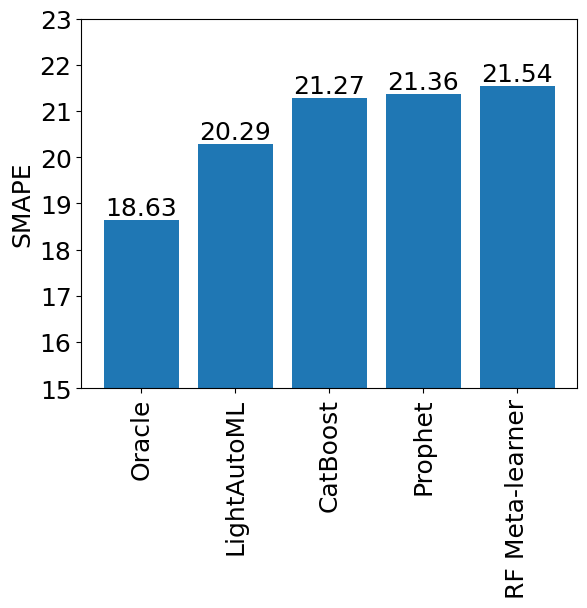

In [17]:
scores = [18.63, 20.29, 21.27, 21.36, 21.54]
models = ['Oracle', 'LightAutoML', 'CatBoost', 'Prophet', 'RF Meta-learner']

bar = plt.bar(models, scores)
plt.bar_label(bar, scores, fontsize=18)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(15,23)
plt.ylabel('SMAPE', fontsize=18)

### Average place calculation for RF

In [18]:
# average place
sum = 0
error_count = 0

for num, idx in enumerate(X_test.index):
  try:
    sum+=df[df['naming_orig'] == df_test.iloc[idx]['naming_orig']].sort_values(by='SMAPE')['model_name'].to_list().index(encoder.classes_[y_pred[num]])
  except ValueError:
    error_count+=1
average_place = sum/(X_test.shape[0]-error_count) +1
print(average_place)

8.194656488549619


### Cells below are more about time computation, no need to execute

In [30]:
# time computation for gl_models
gl_models = []
not_gl_models = []
for model in df_test['model_name'].unique():
  if df[df['model_name'] == model]['forecast_time'].nunique() <4:
    gl_models.append(model)
  else:
    not_gl_models.append(model)

times = []
for model in gl_models:
  avr_time = np.sum(df[df['model_name'] == model]['train_time'].unique())/df[df['model_name'] == model].shape[0]
  avr_time += np.sum(df[df['model_name'] == model]['forecast_time'].unique())/df[df['model_name'] == model].shape[0]
  times.append(avr_time)
training_times = dict(zip(gl_models, times))

In [32]:
df_test

,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,naming_orig,model_name,dataset_name,horizon,split,pred_time
5,3.485261,4.376619,31.675829,2146.546387,46.330836,1.006528,0.817442,3.720475e+01,15.833664,danish_atm_daily_10,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
10,3.485261,4.376619,4.639283,33.564716,5.793506,0.761524,0.750370,2.829478e+01,12.601240,danish_atm_daily_43,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
12,3.485261,4.376619,8.700709,131.790878,11.480021,0.947016,0.963304,6.420407e+01,20.971109,danish_atm_daily_83,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
13,3.485261,4.376619,29.393009,1674.624390,40.922175,0.959978,0.935666,3.555662e+01,13.525134,danish_atm_daily_18,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
23,3.485261,4.376619,21.792171,792.871155,28.157968,0.877460,0.781017,2.506163e+01,11.441988,danish_atm_daily_64,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30746,0.647299,0.138729,4.886311,35.684933,5.973687,1.051572,0.921082,2.271718e+16,21.219864,nn5_58,ARIMAEtna,nn5,30,validation,NaN
30748,0.670703,0.135760,6.002860,43.961048,6.630313,1.111487,0.901808,3.930101e+01,15.870632,nn5_43,ARIMAEtna,nn5,30,validation,NaN
30754,0.419969,0.137903,4.499452,32.417446,5.693632,1.052024,0.926534,2.162086e+01,11.645086,nn5_83,ARIMAEtna,nn5,30,validation,NaN
30757,0.468085,0.144028,9.486559,141.433929,11.892600,0.975079,0.881848,5.728124e+01,23.131987,nn5_101,ARIMAEtna,nn5,30,validation,NaN


In [20]:
# Metaclassifier
errors = 0
sum = 0
time = 0
other_models = []
for num, idx in enumerate(X_test.index):
  try:
    sum+=df[(df['naming_orig'] == df_test.loc[idx]['naming_orig'])&(df['model_name'] == encoder.classes_[y_pred[num]])]['SMAPE'].to_list()[0]
    if encoder.classes_[y_pred[num]] in not_gl_models:
      time+= df[(df['naming_orig'] == df_test.loc[idx]['naming_orig'])&(df['model_name'] == encoder.classes_[y_pred[num]])]['train_time'].to_list()[0] + df[(df['naming_orig'] == df_test.iloc[idx]['naming_orig'])&(df['model_name'] == encoder.classes_[y_pred[num]])]['forecast_time'].to_list()[0]
    else:
      other_models.append(encoder.classes_[y_pred[num]])
  except IndexError:
    errors+=1

for model in other_models:
  time+=training_times[model]
print(f'Average SMAPE: {sum/(X_test.shape[0] - errors)}')
print(f'Average time: {time/(X_test.shape[0] - errors)}')

KeyError: 1

In [21]:
# Prophet
score = 0
errors = 0
time = 0
for num, idx in enumerate(X_test.index):
  try:
    score+=df[(df['naming_orig'] == df_test.iloc[idx]['naming_orig'])&(df['model_name'] == 'Prophet')]['SMAPE'].to_list()[0]
    time+= df[(df['naming_orig'] == df_test.iloc[idx]['naming_orig'])&(df['model_name'] == 'Prophet')]['train_time'].to_list()[0] + df[(df['naming_orig'] == df_test.iloc[idx]['naming_orig'])&(df['model_name'] == 'Prophet')]['forecast_time'].to_list()[0]
  except IndexError:
    errors+=1

print(f'Average SMAPE: {score/(X_test.shape[0] - errors)}')
print(f'Average time: {time/(X_test.shape[0] - errors)}')

Average SMAPE: 21.086605985201043
Average time: 1.0226815483952296


In [22]:
# Oracle
score = 0
time = 0
for num, idx in enumerate(X_test.index):
    score+=df[(df['naming_orig'] == df_test.iloc[idx]['naming_orig'])&(df['model_name'] == df_test.iloc[idx]['model_name'])]['SMAPE'].to_list()[0]
    time+= df[(df['naming_orig'] == df_test.iloc[idx]['naming_orig'])&(df['model_name'].isin(not_gl_models))]['forecast_time'].sum() + df[(df['naming_orig'] == df_test.iloc[idx]['naming_orig'])&(df['model_name'].isin(not_gl_models))]['train_time'].sum()

time+=np.sum(list(training_times.values())) * X_test.shape[0]

print(f'Average SMAPE: {score/X_test.shape[0]}')
print(f'Average time: {time/X_test.shape[0]}')

Average SMAPE: 27.60701675024879
Average time: 14537.459235756807


# OneVSRest Classifier

In [24]:
# train
models = [RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42) for _ in range(df['model_name'].nunique())]
for num, model in enumerate(df_train['model_name'].unique()):
    cuted_df = df_train[df_train['model_name'] == model].drop(['split', 'horizon',  'RMSE', 'RMSSE', 'MSE', 'MASE', 'MAE',
       'MAPE','dataset_name','pred_time', 'model_name', 'train_time', 'forecast_time',	'SMAPE'], axis=1)
    cuted_df['check'] = cuted_df['naming_orig'].apply(lambda x: df_train[df_train['naming_orig'] == x].sort_values(by='SMAPE')['model_name'].to_list().index(model)<8)
    df_merged = pd.merge(cuted_df, feat)
    y = df_merged['check']
    X = df_merged.drop(['check', 'naming_orig'], axis=1)
    models[num].fit(X,y)


In [25]:
# predict

predicts = pd.DataFrame(X_test['naming_orig'])

for num, model in enumerate(df_train['model_name'].unique()):
    predicts[model] = models[num].predict_proba(X_test.drop('naming_orig', axis=1))[:,1] 
predicts['best_model'] = predicts.drop('naming_orig', axis=1).idxmax(axis=1)

errors = 0
sum = 0
for num, idx in enumerate(predicts.index):
  try:
    sum+=df[(df['naming_orig'] == predicts.loc[idx]['naming_orig'])&(df['model_name'] == predicts.loc[idx]['best_model'])&(df['split'] == 'validation')]['SMAPE'].to_list()[0]
  except IndexError:
    errors+=1

print(errors)
print(sum/(X_test.shape[0] - errors))

6
20.193872672098223


Text(0, 0.5, 'Probability')

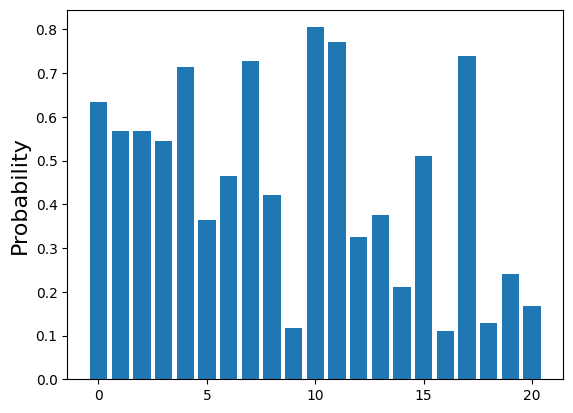

In [26]:
l = predicts.loc[1].tolist()[2:-1]
plt.bar(np.arange(len(l)), l)
plt.rcParams['figure.figsize']=6,4
plt.ylabel('Probability', fontsize=16)

In [27]:
predicts['best_model'].value_counts()

best_model
LightAutoML_mult_gl                                  69
TFTTuningObjective_gl                                68
LightAutoML                                          67
CatBoostAutoRegressivePipelineEtna_30lags            22
CatBoostAutoRegressivePipelineEtna_horizonlags       10
Prophet                                              10
CatBoostDirectPipelineEtna_horizonlags_gl             5
NeuralProphet_gl                                      4
CatBoostDirectPipelineEtna_30lags_gl                  4
CatBoostAutoRegressivePipelineEtna_horizonlags_gl     2
CatBoostAutoRegressivePipelineEtna_30lags_gl          1
Name: count, dtype: int64

In [259]:
# hyperparameter tuning
for top in range(2,15):
    train_list = Train_df.to_list()
    df_valid_train = df[(df['split'] == 'validation')&(df['naming_orig'].isin(train_list))&(df['model_name']!= 'TFTTuningObjective')&((df['model_name']!= 'DeepARTuningObjective'))]
    models = [RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42) for _ in range(df['model_name'].nunique())]
    for num, model in enumerate(df_valid_train['model_name'].unique()):
        cuted_df = df_valid_train[df_valid_train['model_name'] == model].drop(['split', 'horizon',  'RMSE', 'RMSSE', 'MSE', 'MASE', 'MAE',
        'MAPE','dataset_name','pred_time', 'model_name', 'train_time', 'forecast_time',	'SMAPE'], axis=1)
        cuted_df['check'] = cuted_df['naming_orig'].apply(lambda x: df_valid_train[df_valid_train['naming_orig'] == x].sort_values(by='SMAPE')['model_name'].to_list().index(model)<top)
        df_merged = pd.merge(cuted_df, feat)
        y = df_merged['check']
        X = df_merged.drop(['check', 'naming_orig'], axis=1)
        models[num].fit(X,y)

    # predict
    test_list = Holdout.to_list()
    X_test = feat[feat['naming_orig'].isin(test_list)]
    predicts = pd.DataFrame(X_test['naming_orig'])
    X_test.drop('naming_orig', axis=1, inplace=True)
    for num, model in enumerate(df_valid_train['model_name'].unique()):
        predicts[model] = models[num].predict_proba(X_test)[:,1] 
    predicts['best_model'] = predicts.drop('naming_orig', axis=1).idxmax(axis=1)

    errors = 0
    sum = 0
    for num, idx in enumerate(predicts.index):
        try:
            sum+=df[(df['naming_orig'] == predicts.loc[idx]['naming_orig'])&(df['model_name'] == predicts.loc[idx]['best_model'])&(df['split'] == 'validation')]['SMAPE'].to_list()[0]
        except IndexError:
            errors+=1

    print(f'Top: {top}')
    print(f'Num errors: {errors}')
    print(f'Score: {sum/(X_test.shape[0] - errors)}')

C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 2
Num errors: 7
Score: 21.778547502323693


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 3
Num errors: 3
Score: 21.774364782058594


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 4
Num errors: 2
Score: 21.405125310501226


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 5
Num errors: 2
Score: 20.91559308795975


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 6
Num errors: 3
Score: 21.653412583079117


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 7
Num errors: 8
Score: 20.32486431916633


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 8
Num errors: 6
Score: 20.193872672098223


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 9
Num errors: 20
Score: 21.29118783969032


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 10
Num errors: 16
Score: 20.991099860549458


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 11
Num errors: 16
Score: 20.72492631652006


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 12
Num errors: 1
Score: 21.263781783681264


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 13
Num errors: 11
Score: 21.564654387029044


C:\Users\User\AppData\Local\Temp\ipykernel_6768\3613909645.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('naming_orig', axis=1, inplace=True)


Top: 14
Num errors: 7
Score: 22.13746259755948


Text(0.5, 0, 'N')

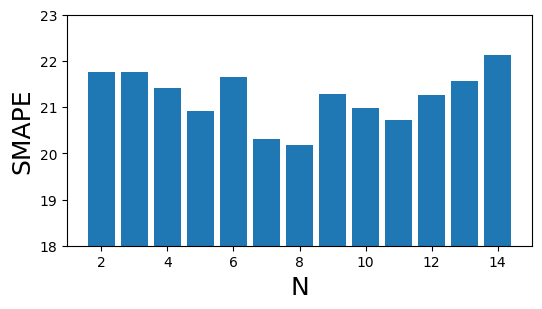

In [341]:
scores = [21.77, 21.77, 21.41, 20.91, 21.65, 20.32, 20.19, 21.29, 20.99, 20.72, 21.26, 21.56, 22.13]
top = np.arange(2,15)
plt.bar(top, scores)
plt.rcParams['figure.figsize']=6,2
plt.ylim(18,23)
plt.ylabel('SMAPE', fontsize=18)
plt.xlabel('N', fontsize=18)

Text(0, 0.5, 'SMAPE')

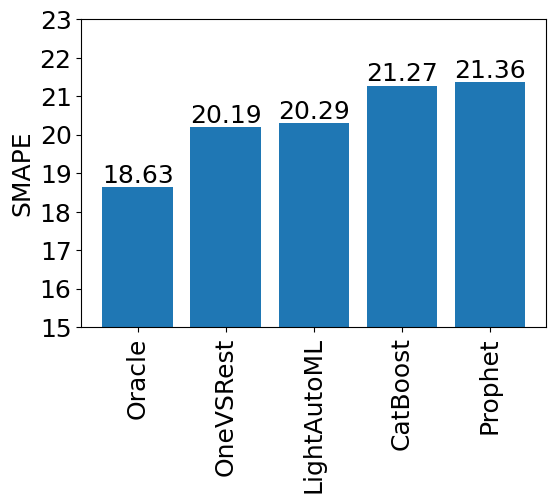

In [28]:
scores = [18.63, 20.19, 20.29, 21.27, 21.36]
models = ['Oracle', 'OneVSRest', 'LightAutoML', 'CatBoost', 'Prophet']

bar = plt.bar(models, scores)
plt.bar_label(bar, scores, fontsize=18)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(15,23)
plt.ylabel('SMAPE', fontsize=18)